# Provando ad implementare il codice di un articolo

- [Ispirazione](https://paperswithcode.com/paper/deep-learning-for-ecg-segmentation)
- [Paper](https://arxiv.org/pdf/2001.04689.pdf)
- [Dataset](https://physionet.org/content/ludb/1.0.1)
- [Altro Notebook](https://www.kaggle.com/yschii/find-ecg-wave)


A dir la verità non sono sicuro che il db sia quello giusto. 
Nel paper parlano di 455 ecg a 12 derivazioni, ma in quello che ho scaricato ce ne sono 200

https://www.wintips.org/fix-cpu-not-running-at-full-speed-in-windows-10/#

In [1]:
# first of all install necessary packages
%pip install -U wfdb
%matplotlib inline

You should consider upgrading via the 'C:\Users\scala\lang\python.exe -m pip install --upgrade pip' command.


Requirement already up-to-date: wfdb in c:\users\scala\lang\lib\site-packages (3.4.1)
Note: you may need to restart the kernel to use updated packages.


In [2]:
# then import necessary packages
import wfdb

import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K



from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1DTranspose, BatchNormalization, Activation, Conv1D, ZeroPadding1D, MaxPooling1D, Concatenate

from tensorflow.keras.optimizers import Adam, SGD, RMSprop



# https://stackoverflow.com/questions/66100195/a-tf-variable-created-inside-my-tf-function-has-been-garbage-collected
tf.config.run_functions_eagerly(False)

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical



### Explore some data

In [3]:
# since the paper handles 12 lead ECG data, i will use 12 leads
LEADS = ['avf', 'avl', 'avr', 'i', 'ii', 'iii', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
DATA_FOLDER = "./lobachevsky-university-electrocardiography-database-1.0.1/data"
SEGMENT_TO_COLOR = {
    'N': 'blue',
    't': 'green',
    'p': 'red'
}
ECG_SIZE = 512
assert ECG_SIZE % 8 == 0

In [4]:
from typing import Union,List, Tuple

# get signal with wfdb library
# using an index
def get_signal(index:int, as_p_signal:bool=True) -> Union[wfdb.Record, np.ndarray]:
    record = wfdb.rdrecord(DATA_FOLDER + "/" +  str(index))
    assert type(record) is wfdb.Record

    if as_p_signal:
        assert type(record.p_signal) is np.ndarray
        return record.p_signal
        
    return record

# get annotations given the ecg lead
def get_annotations(index:int, lead, as_sample=True) -> Union[wfdb.Annotation, np.ndarray]:
    annotations = wfdb.rdann(DATA_FOLDER +"/" + str(index), extension = lead)
    if as_sample:
        return np.array(annotations.sample)
    return annotations

# get a full EGC with 12 leads
def get_full_ecg(index:int):
    signal = get_signal(index)
    annotations = [
        get_annotations(index, lead) for lead in LEADS
    ]
    return signal, annotations


def get_single_lead_ecg(index, lead) -> Tuple[np.ndarray, np.ndarray]:
    """
    return and ecg signal and its annotations
    both as ndarray
    """
    signal = get_signal(index)
    assert type(signal) is np.ndarray
    signal = signal[:, LEADS.index(lead)]

    samples = get_annotations(index, lead)
    assert type(samples) is np.ndarray
    
    return signal, samples


def get_annotations_symbols(index, lead):
    ann = get_annotations(index, lead, as_sample=False)
    return ann.symbol

def paired_annotation_sample_and_symbol(index, lead):
    annotations_symbols = get_annotations_symbols(index, lead)
    annotations_sample = get_annotations(index, lead)
    return zip(annotations_sample, annotations_symbols)


def get_single_lead_ecg_with_symbols(index, lead):
    """
    return and ecg signal and its annotations
    both as ndarray
    """
    signal = get_signal(index)
    assert type(signal) is np.ndarray
    signal = signal[:, LEADS.index(lead)]

    data = paired_annotation_sample_and_symbol(index, lead)
    
    return signal, np.array(list(data))

# plot single lead ecg with annotations
def plot_single_lead_ecg(index, lead):
    signal, samples = get_single_lead_ecg(index, lead)

    fig, ax = plt.subplots(figsize = (28, 3))

    ax.plot(signal)
    ax.scatter(samples, signal[samples], c = 'r', marker = 'o')


# now plot every lead with annotations
def plot_signal_with_annotation(index):
    signal, samples = get_full_ecg(index)
    # extract sample from annotations
    wfdb.plot_items(signal, samples )


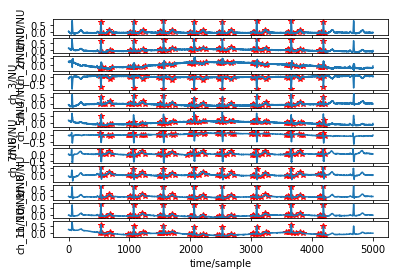

In [5]:
plot_signal_with_annotation(199)   

### Plotto anche una sola derivazione
La descrizione dell'articolo dice che gli ECG sono lunghi 10sec. Se in 10sec sono stati presi 5000 campioni, allora l'ECG andava a 500Hz.

In [6]:
def grouped(itr, n=3):
    itr = iter(itr)
    end = object()
    while True:
        vals = tuple(next(itr, end) for _ in range(n))
        if vals[-1] is end:
            return
        yield vals

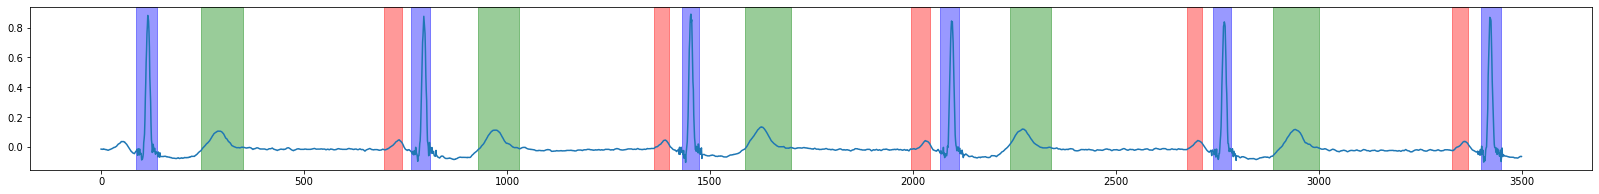

In [7]:
class EGCSignal:
    def __init__(self, signal, time_points, symbol, categories = None):
        """
        signal: ndarray

        """
        self.signal:np.ndarray = signal
        self.time_points:np.ndarray = time_points
        self.symbols:list[str] = symbol
        self.symbol_to_category = {
            'N': 0,
            't': 1,
            'p': 2
        }
        self.category_to_symbol = {
            0: 'N',
            1: 't',
            2: 'p'
        }
        self.categories = categories if categories is not None else self.symbols_to_category()
        self._cut_beginning( 550)
        self._cut_end( 3500)

    def __getitem__(self, key):
        return self.signal[key]

    def __len__(self):
        return len(self.signal)

    def _cut_beginning(self, start_point):
        self.signal = self.signal[start_point:]
        self.categories = self.categories[start_point:]

        # now have to check if time_points and symbols are also to cut
        if start_point > self.time_points[0]:
            # get the index of the first time point greater than start_point
            index = np.argmax(self.time_points > start_point)                
            self.time_points = self.time_points[index:]
            self.symbols = self.symbols[index:]

        self.time_points = self.time_points - start_point

        # check the cut point
        if self.categories[0] != -1:
            # if the first symbol is a ')' then i have to prepend a '(' and a letter from self.category_to_symbol
            if self.symbols[0] == ')':
                self.symbols = ['('] + [self.category_to_symbol[self.categories[0]]] + self.symbols
                self.time_points = np.concatenate(([0,1], self.time_points))
            elif self.symbols[0] in self.symbol_to_category:
                # just prepend '('
                self.symbols = ['('] + self.symbols
                self.time_points = np.concatenate(([0], self.time_points))

    def _cut_end(self, end_point):
        self.signal = self.signal[:end_point]
        self.categories = self.categories[:end_point]

        index = self.time_points[self.time_points < self.signal.size].size
        self.time_points = self.time_points[:index]
        self.symbols = self.symbols[:index]

        # check the cut point
        if self.categories[-1] != -1:
            # if the last symbol is a '(' then i have to append a ')' and a letter from self.category_to_symbol
            if self.symbols[-1] == '(':
                self.symbols = self.symbols +  [self.category_to_symbol[self.categories[-1]]] + [')']
                self.time_points = np.concatenate((self.time_points, [self.signal.size - 1, self.signal.size ]))
            elif self.symbols[-1] in self.symbol_to_category:
                # just append ')'
                self.symbols = self.symbols + [')']
                self.time_points = np.concatenate((self.time_points, [self.signal.size]))
 
    def plot(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize = (28, 3))
        ax.plot(self.signal)

    def plot_with_time_point(self):
        fig, ax = plt.subplots(figsize = (28, 3))
        self.plot(ax)
        ax.scatter(self.time_points, self.signal[self.time_points], c = 'r', marker = 'o')

    def plot_with_segments(self):
        fig, ax = plt.subplots(figsize = (28, 3))
        self.plot(ax)

        for start, symbol, end in grouped(self.time_points, 3):            
            i = np.nonzero(self.time_points == symbol)[0][0]
            current_symbol = self.symbols[i]
            color = SEGMENT_TO_COLOR[current_symbol]
            ax.axvspan(start, end, color=color, alpha=0.4)

    def symbols_to_category(self):
        """
        converts the symbols list in a numpy array of integers
        same length as the signal
        """

        # first instantiate an array of -1 same length as the signal
        category = np.full(len(self.signal), -1)
        # now fill the array with the known category
        for section in grouped(self.time_points):
            # unpack the section
            start, peak, end = section
            
            
            # get the category given the peak
            i = np.nonzero(self.time_points == peak)[0][0]
            current_symbol = self.symbols[i]

            category[start:end] = self.symbol_to_category[current_symbol]

        return category

    @staticmethod
    def from_index_and_lead(index, lead):
        return EGCSignal(
        get_signal(index)[:, LEADS.index(lead)],
        get_annotations(index, lead),
        get_annotations_symbols(index, lead) )



EGCSignal.from_index_and_lead(1, LEADS[0]).plot_with_segments()


Per qualche ragione, non tutti gli ecg escono col buco e certi mi risultano annotati male quindi non li considerero nel dataset
Farò una lista per escluderli.

In [8]:
# create a list of not working ecgs
not_working_ecgs = []
for i in range(1,200):
    for lead in LEADS:
        try: EGCSignal.from_index_and_lead(i, lead)
        except: not_working_ecgs.append((i, lead))

### Incomincio a preparare X e Y per la rete
siccome mi sono un po scomodi i dati, mi faccio un classe per rappresenatare tutto

In [98]:
import random


X = []
Y = []
for ecg_index in range(1,200):
    for lead in LEADS:
        if (ecg_index, lead) not in not_working_ecgs:
            for ecg_part in range(0, 3):
                s = EGCSignal.from_index_and_lead(ecg_index, lead)

                span = ECG_SIZE
                start = random.randint(0, 30) + ecg_part*span
                s._cut_beginning(start)
                s._cut_end(span)

                # append the signal to X, also adding a new dimension
                X.append(s.signal)
                # append the category to Y
                Y.append(to_categorical(s.categories + 1, num_classes = 4).astype(np.float32))


In [100]:


class ConvPassLayer(layers.Layer):
    def __init__(self, n_conv_filters, activation='relu', padding_size = 4, **kwargs):
        super(ConvPassLayer, self).__init__(**kwargs)
        # parameters
        self.n_conv_filters = n_conv_filters
        self.activation = activation
        self.padding_size = padding_size
        # layers
        self.zero_padding = ZeroPadding1D(padding=self.padding_size)
        self.conv = Conv1D(filters = self.n_conv_filters, kernel_size = 9)
        self.batch_norm = BatchNormalization()
        self.activation_layer = Activation(self.activation)

    def build(self, input_shape):
        self.input_layer = input_shape

    def call(self, x):
        # apply 4 padding in 1 dimension
        pad1 = self.zero_padding(x)
        # apply a convolution with kernel size 9
        conv1 = self.conv(pad1)
        # apply batch normalization
        bn1 = self.batch_norm(conv1)
        # apply activation function
        act1 = self.activation_layer(bn1)
        return act1

    def compute_output_shape(self, input_shape):
        return input_shape

class DownPassLayer(layers.Layer):
    def __init__(self, n_conv_filters, activation='relu', padding_size = 4, **kwargs):
        super(DownPassLayer, self).__init__(**kwargs)
        # parameters
        self.n_conv_filters = n_conv_filters
        self.activation = activation
        self.padding_size = padding_size
        # layers
        self.max_pool = MaxPooling1D(pool_size = 2)
        self.conv_pass_layer1 = ConvPassLayer(self.n_conv_filters, self.activation, self.padding_size)
        self.conv_pass_layer2 = ConvPassLayer(self.n_conv_filters, self.activation, self.padding_size)

    def build(self, input_shape):
        self.input_layer = input_shape

    def call(self, x):
        x = self.max_pool(x)
        x = self.conv_pass_layer1(x)
        x = self.conv_pass_layer2(x)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape//2

class UpPassLayer(layers.Layer):
    def __init__(self, n_conv_filters, activation='relu', padding_size = 4, **kwargs):
        super(UpPassLayer, self).__init__(**kwargs)
        # parameters
        self.n_conv_filters = n_conv_filters
        self.activation = activation
        self.padding_size = padding_size
        # layers
        # applys two convolution and pooling layers
        self.deconv = Conv1DTranspose(filters = self.n_conv_filters, kernel_size = 8, strides = 2, padding = 'same')
        self.concat = Concatenate()
        self.conv_pass_layer1 = ConvPassLayer(self.n_conv_filters//2, self.activation, self.padding_size)
        self.conv_pass_layer2 = ConvPassLayer(self.n_conv_filters//2, self.activation, self.padding_size)

    def build(self, input_shape):
        self.input_layer = input_shape

    def call(self, same_layer, lower_layer):
        deconv = self.deconv(lower_layer)
        conc = self.concat([same_layer, deconv])
        conv1 = self.conv_pass_layer1(conc)
        conv2 = self.conv_pass_layer2(conv1)
        
        return conv2

    def compute_output_shape(self, input_shape):
        return input_shape


def UNET(inpusize =ECG_SIZE):
    inputs = Input((inpusize, 1))
    block1layer1 = ConvPassLayer(4)(inputs)
    block1layer2 = ConvPassLayer(4)(block1layer1)

    block2layer2 = DownPassLayer(8)(block1layer2)

    block3layer2 = DownPassLayer(16)(block2layer2)

    block4layer2 = DownPassLayer(32)(block3layer2)


    pool4 = MaxPooling1D(2)(block4layer2)
    block5layer1 = ConvPassLayer(64)(pool4)
    block5layer2 = ConvPassLayer(64)(block5layer1)


    block4up = UpPassLayer(64)(block4layer2, block5layer2)

    block3up = UpPassLayer(32)(block3layer2, block4up)
    block2up = UpPassLayer(16)(block2layer2, block3up)

    

    transposed1 = Conv1DTranspose(filters = 8, kernel_size = 8, strides = 2, padding = 'same')(block2up)
    block1layer3 = Concatenate()([transposed1, block1layer2])
    block1layer4 = ConvPassLayer(4)(block1layer3)
    block1layer5 = ConvPassLayer(4, activation='softmax')(block1layer4)

    return Model(inputs, block1layer5)


m = UNET()
m.summary()
print(f"""
{m.predict(X[0].reshape(1, ECG_SIZE, 1))[0]}

""")


Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 1024, 1)]    0           []                               
                                                                                                  
 conv_pass_layer_252 (ConvPassL  (None, 1024, 4)     56          ['input_15[0][0]']               
 ayer)                                                                                            
                                                                                                  
 conv_pass_layer_253 (ConvPassL  (None, 1024, 4)     164         ['conv_pass_layer_252[0][0]']    
 ayer)                                                                                            
                                                                                           

forse dovrei provare ad abbassare un altro po la dimensione dei batch e il learning rate

In [101]:
m = UNET()

# create an optimizer
opt = Adam(learning_rate=0.0005)

m.compile(optimizer=opt, loss='binary_crossentropy') 


# split the data in train and test
X_train, X_test, Y_train, Y_test = train_test_split(
    np.array(X),#X,
    np.array(Y, dtype=np.float32),#Y,
    test_size=0.31)

train_history = m.fit(
    X_train, Y_train,
    epochs=17,
    batch_size=8,
    validation_data=(X_test, Y_test)
)


Epoch 1/17
611/611 [==============================] - 105s 154ms/step - loss: 0.4626 - val_loss: 0.3967
Epoch 2/17
611/611 [==============================] - 93s 152ms/step - loss: 0.3493 - val_loss: 0.3179
Epoch 3/17
611/611 [==============================] - 97s 159ms/step - loss: 0.2881 - val_loss: 0.2653
Epoch 4/17
611/611 [==============================] - 93s 152ms/step - loss: 0.2453 - val_loss: 0.2324
Epoch 5/17
611/611 [==============================] - 101s 165ms/step - loss: 0.2137 - val_loss: 0.2063
Epoch 6/17
611/611 [==============================] - 96s 157ms/step - loss: 0.1900 - val_loss: 0.1839
Epoch 7/17
611/611 [==============================] - 85s 139ms/step - loss: 0.1723 - val_loss: 0.1659
Epoch 8/17
611/611 [==============================] - 84s 138ms/step - loss: 0.1582 - val_loss: 0.1579
Epoch 9/17
611/611 [==============================] - 90s 147ms/step - loss: 0.1468 - val_loss: 0.1459
Epoch 10/17
611/611 [==============================] - 99s 161ms/step -

KeyboardInterrupt: 

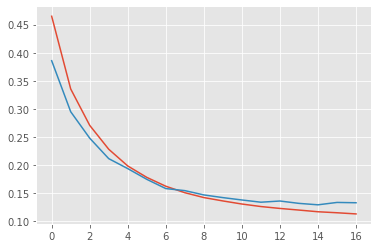

In [25]:
# plot the training loss and accuracy
# plt.style.use("ggplot")
plt.figure()
plt.plot(train_history.history["loss"], label="train loss")
plt.plot(train_history.history["val_loss"], label="val loss")

### Misurando l'algoritmo

The quality of the algorithms is determined using the following procedure.
According to the recommendations of the Association for Medical Instrumentation, it is considered that an onset or an offset are detected correctly, if
their deviation from the doctor annotations does not exceed in absolute value
the tolerance of 150 ms.

```
Frequenza ecg nel dataset = 500hz
-> 500campioni/sec
-> 5camp/10ms (5campioni durano un tempo di 10ms)
-> 75 campioni coprono un arco di 150ms

Se la distanza tra l'annotazione del modello e quella del dottore non distano piu di 75 valori
allora posso dire che il modello ha annotato bene
```

If an algorithm correctly detects a significant point (an onset or an offset of one of the P, QRS, T segments), then a true positive result (TP) is counted and the time deviation (error) of the automatic determined point from the manually marked point is measured.
If there is no corresponding significant point in the test sample in the neighborhood of ±tolerance of the detected significant point, then the I type error is counted (false positive – FP).
If the algorithm does not detect a significant point, then the II type error is counted (false negative – FN).

```

TP = tutti quelli nella tolleranza (75campioni)
FP = se l'algoritno annota, ma non c'è nulla (di annotato) nella tolleranza
FN = se l algoritno non annota ma c'è qualcosa

Per l'algoritmo devo misurare
    per ogni onset/offset
        per ogni onda
            media e std dev
            recall = TP/(TP + FN)
            precision= TP/(TP + FP)
            f1 = 2 * (recall*precision) / (recall+precision) 

```





In [64]:
Y_test_pred = m.predict(X_test)
toll = 75

In [79]:
def find_wave_onset(wave_category:list) -> list:
    onsets = []
    prev = None
    for i, val in enumerate(wave_category):
        if val != 0 and prev == 0:
            onsets.append(i)
        prev = val
    return onsets

def find_wave_offset(wave_category:list) -> list:
    offsets = []
    prev = None
    for i, val in enumerate(wave_category):
        if val != 0 and prev == 0:
            offsets.append(i)
        prev = val
    return offsets


errors = []
TP = 0
for y_test, y_pred in zip(Y_test, Y_test_pred):
    y_test_cat = np.argmax(y_test, axis=1)
    y_pred_cat = np.argmax(y_pred, axis=1)

    onset_test = np.array(find_wave_onset(y_test_cat))
    onset_pred = np.array(find_wave_onset(y_pred_cat))

    offset_test = np.array(find_wave_offset(y_test_cat))
    offset_pred = np.array(find_wave_offset(y_pred_cat))

    if len(onset_test) > len(onset_pred):
        pass #print("some FN")
    elif len(onset_test) < len(onset_pred):
        pass #print("some FP")
    else:
        onsetTP = np.sum(np.abs(onset_test - onset_pred) < toll)
        offsetTP = np.sum(np.abs(offset_test - offset_pred) < toll)
        TP += onsetTP + offsetTP
        errors.append(
            list(np.abs(onset_test - onset_pred)) + list(np.abs(offset_test - offset_pred))
        )




In [86]:
# flatten list of lists
errors = [item for sublist in errors for item in sublist]

In [87]:
err = np.ravel(errors)
err.mean(), err.std()

(10.543599553642595, 27.646836582416405)

### Qualche visualizzazione

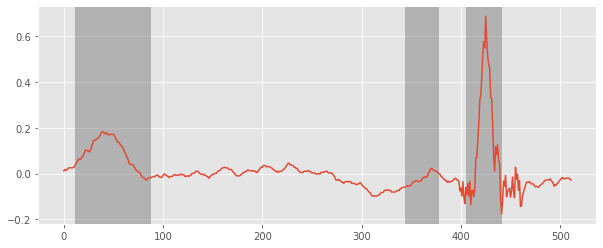

In [88]:
# plot categories on ecg
ecg_index = 11
signal = X_test[ecg_index]
categories = np.argmax(Y_test[ecg_index], axis=1)
predicted_categories = np.argmax(m.predict(signal[np.newaxis, : ])[0], axis=1)

# get time point where category changes
time_points = np.where(categories[:-1] != categories[1:])[0]

# chek if category was at beginning or end
if categories[0] != 0:
    # if category was at beginning, add first time point
    time_points = np.append(0, time_points)
if categories[-1] != 0:
    # if category was at end, add last time point
    time_points = np.append(time_points, len(categories))

# plot the signal
plt.figure(figsize=(10, 4))
plt.plot(signal)
for b,e in grouped(time_points, 2):
    plt.axvspan(b, e, facecolor='0.5', alpha=0.5)


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

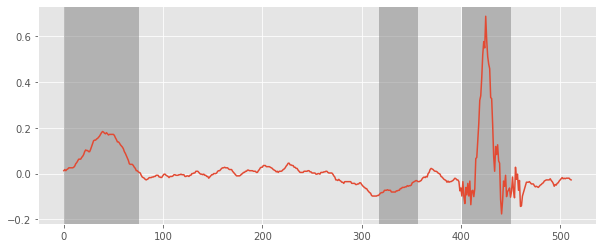

In [96]:

signal = X_test[ecg_index]
categories = np.argmax(Y_test[ecg_index], axis=1)
predicted_categories = np.argmax(m.predict(signal[np.newaxis, : ])[0], axis=1)

# get time point where category changes
time_points = np.where(predicted_categories[:-1] != predicted_categories[1:])[0]


# chek if category was at beginning or end
if predicted_categories[0] != 0:
    # if category was at beginning, add first time point
    time_points = np.append(0, time_points)
if predicted_categories[-1] != 0:
    # if category was at end, add last time point
    time_points = np.append(time_points, len(predicted_categories))

# plot the signal
plt.figure(figsize=(10, 4))
plt.plot(signal)
for b,e in grouped(time_points, 2):
    plt.axvspan(b, e, facecolor='0.5', alpha=0.5)

predicted_categories

In [90]:
pred = m.predict(signal[np.newaxis, : ])[0]

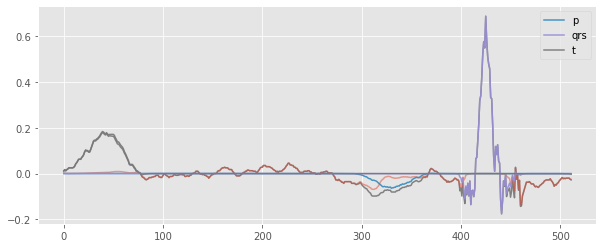

In [91]:
plt.figure(figsize=(10, 4))

plt.plot(signal, color = "gray")
plt.plot(pred[:,0]*signal, alpha=0.5) # predicted not interesting

plt.plot(pred[:,3]*signal, alpha=0.9, label= "p") # predicted p

plt.plot(pred[:,1]*signal, alpha=0.9, label= "qrs") # predicted qrs
plt.plot(pred[:,2]*signal, alpha=0.9, label= "t") # predicted t

plt.legend(
    loc='upper right',
    ncol=1,

)

(-0.17632241813602015, 0.6876574307304786)

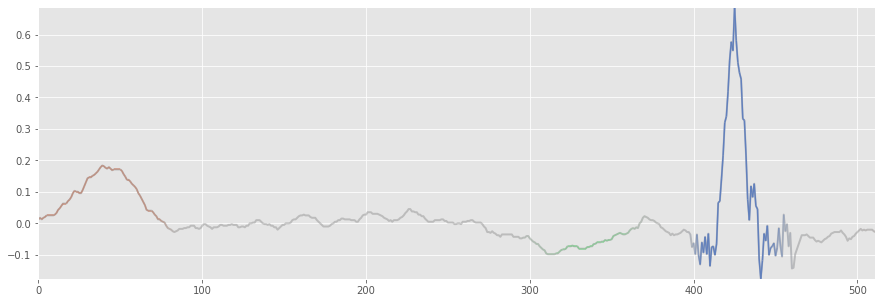

In [97]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap

x   = np.arange(len(signal)) 
y   = signal
t = np.linspace(0,1,x.shape[0]) # your "time" variable

# set up a list of (x,y) points
points = np.array([x,y]).transpose().reshape(-1,1,2)

# set up a list of segments
segs = np.concatenate([points[:-1],points[1:]],axis=1)

# matplotlib starndard RGBA colors

lightblue  = [(0.3, 0.5, 0.9, 0.99 * p) for p in pred[:,1]]
lightred   = [(0.9, 0.6, 0.5, 0.99 * p) for p in pred[:,2]]
lightgreen = [(0.5, 0.99, 0.6, 0.99 * p) for p in pred[:,3]]

# make the collection of segments
lcblue = LineCollection(segs, cmap=ListedColormap( lightblue))
lcblue.set_array(t) # color the segments by our parameter

lcred = LineCollection(segs, cmap=ListedColormap( lightred))
lcred.set_array(t) # color the segments by our parameter

lcgreen = LineCollection(segs, cmap=ListedColormap( lightgreen))
lcgreen.set_array(t) # color the segments by our parameter


# plot the collection
plt.figure(figsize=(15, 5))
plt.plot(signal, alpha = 0.4, linewidth = 2, color='gray')
plt.gca().add_collection(lcblue) # add the collection to the plot
plt.gca().add_collection(lcred) # add the collection to the plot
plt.gca().add_collection(lcgreen) # add the collection to the plot
plt.xlim(x.min(), x.max()) # line collections don't auto-scale the plot
plt.ylim(y.min(), y.max())